In [86]:
#сверточная нейронная сеть

# подключаем библиотеки
import os
import cv2
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

from pathlib import Path
from collections import Counter
from sklearn.model_selection import train_test_split


import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

seed = 1234


Number of images found:  302


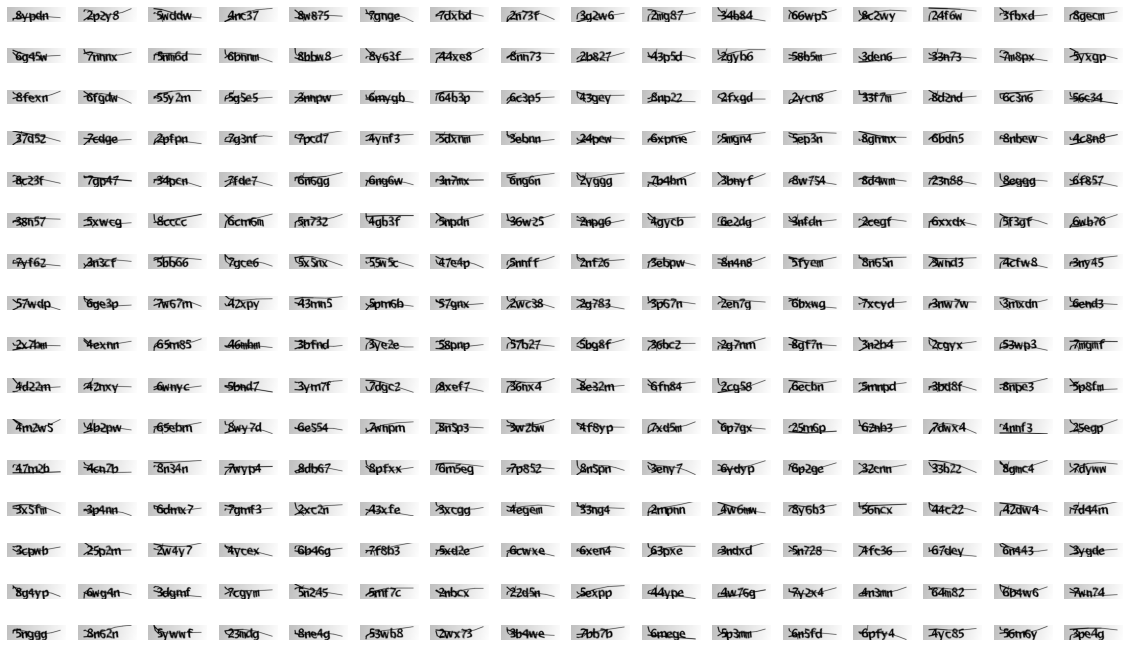

In [ ]:
data_dir = Path("/content")



# Список з изображений
images = list(data_dir.glob("*.png"))
print("Number of images found: ", len(images))

#Посмотрим на наши данные 
sample_images = images[:256]

_,ax = plt.subplots(16,16, figsize=(20,12))
for i in range(256):
    img = cv2.imread(str(sample_images[i]))
    
    ax[i//16, i%16].imshow(img)
    ax[i//16, i%16].axis('off')
plt.show()

In [ ]:
# Store all the characters in a set
characters = set()

# A list to store the length of each captcha
captcha_length = []

# Store image-label info
dataset = []

# Iterate over the dataset and store the
# information needed
for img_path in images:
    # 1. Get the label associated with each image
    label = img_path.name.split(".png")[0]
    # 2. Store the length of this cpatcha
    captcha_length.append(len(label))
    # 3. Store the image-label pair info
    dataset.append((str(img_path), label))

        # 4. Store the characters present
    for ch in label:
        characters.add(ch)

# Sort the characters        
characters = sorted(characters)

# Convert the dataset info into a dataframe
dataset = pd.DataFrame(dataset, columns=["img_path", "label"], index=None)

# Shuffle the dataset
dataset = dataset.sample(frac=1.).reset_index(drop=True)
print("Number of unqiue charcaters in the whole dataset: ", len(characters))
print("Maximum length of any captcha: ", max(Counter(captcha_length).keys()))
print("Characters present: ", characters)
print("Total number of samples in the dataset: ", len(dataset))
print('Несколько примеров данных')
dataset.head()

Number of unqiue charcaters in the whole dataset:  19
Maximum length of any captcha:  5
Characters present:  ['2', '3', '4', '5', '6', '7', '8', 'b', 'c', 'd', 'e', 'f', 'g', 'm', 'n', 'p', 'w', 'x', 'y']
Total number of samples in the dataset:  302
Несколько примеров данных


,img_path,label
0,/content/7fde7.png,7fde7
1,/content/57b27.png,57b27
2,/content/25m6p.png,25m6p
3,/content/8ne4g.png,8ne4g
4,/content/57wdp.png,57wdp


In [89]:
#разбиение данных на случайные обучающие и тестовые подмножества
training_data, validation_data = train_test_split(dataset, test_size=0.1, random_state=seed)

#переиндексация строк для устранения неправильной иlнексации во избежаниt влияния на работу модели
training_data = training_data.reset_index(drop=True)
validation_data = validation_data.reset_index(drop=True)

print("Number of training samples: ", len(training_data))
print("Number of validation samples: ", len(validation_data))



# генерируем кортежи, состоящие из двух элементов - индекс и сам элемент 
char_to_labels = {char:idx for idx, char in enumerate(characters)}

# переводим в char
labels_to_char = {val:key for key, val in char_to_labels.items()}

# Проверяем работоспособность поврежденных данных
def is_valid_captcha(captcha):
    for ch in captcha:
        if not ch in characters:
            return False
    return True



# Запишем массивы в памяти
def generate_arrays(df, resize=True, img_height=50, img_width=200):
  num_items = len(df)
  images = np.zeros((num_items, img_height, img_width), dtype=np.float32) #задаем размер входного массива и определяем тип данных 
  labels = [0]*num_items
    
  for i in range(num_items): 
      img = cv2.imread(df["img_path"][i])
      img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        
      if resize: 
          img = cv2.resize(img, (img_width, img_height))
        
      img = (img/255.).astype(np.float32)
      label = df["label"][i]
        
        # если valid_capcha
      if is_valid_captcha(label):
          images[i, :, :] = img
          labels[i] = label
    
  return images, np.array(labels)

# Создаем training data
training_data, training_labels = generate_arrays(df=training_data)
print("Number of training images(depth, height, width): ", training_data.shape)


# Создаем validation data
validation_data, validation_labels = generate_arrays(df=validation_data)
print("Number of validation images (depth, height, width): ", validation_data.shape)


Number of training samples:  14
Number of validation samples:  2
Number of training images(depth, height, width):  (14, 50, 200)
Number of validation images (depth, height, width):  (2, 50, 200)


In [ ]:
class DataGenerator(keras.utils.Sequence):
      def __init__(self,
                 data,
                 labels,
                 char_map,
                 batch_size=16,
                 img_width=200,
                 img_height=50,
                 downsample_factor=4,
                 max_length=5,
                 shuffle=True
                ):
        self.data = data
        self.labels = labels
        self.char_map = char_map
        self.batch_size = batch_size
        self.img_width = img_width
        self.img_height = img_height
        self.downsample_factor = downsample_factor
        self.max_length = max_length
        self.shuffle = shuffle
        self.indices = np.arange(len(data))    
        self.on_epoch_end()
        
      def __len__(self):  #батчи
          return int(np.ceil(len(self.data) / self.batch_size))
      def __getitem__(self, idx):
        # Индексы для батчей
        curr_batch_idx = self.indices[idx*self.batch_size:(idx+1)*self.batch_size]
        batch_len = len(curr_batch_idx)
        
        #  Создание массивов
        batch_images = np.ones((batch_len, self.img_width, self.img_height, 1),
                               dtype=np.float32)
        batch_labels = np.ones((batch_len, self.max_length), dtype=np.float32)
        input_length = np.ones((batch_len, 1), dtype=np.int64) * \
                                (self.img_width // self.downsample_factor - 2)
        label_length = np.zeros((batch_len, 1), dtype=np.int64)
        for j, idx in enumerate(curr_batch_idx):
            # Получаем изображение и транспонируем его
            img = self.data[idx].T
            # Добавляем доп измерение
            img = np.expand_dims(img, axis=-1)
            # Получаем ярлыки
            text = self.labels[idx]
            # Если captcha_valid
            if is_valid_captcha(text):
                label = [self.char_map[ch] for ch in text]
                batch_images[j] = img
                batch_labels[j] = label
                label_length[j] = len(text)
        
        batch_inputs = {
                'input_data': batch_images,
                'input_label': batch_labels,
                'input_length': input_length,
                'label_length': label_length,
                }
        return batch_inputs, np.zeros(batch_len).astype(np.float32)
        
    
      def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indices)
    

In [ ]:
# Размеры батчей
batch_size = 16

# Задаем размеры изображений
img_width=200
img_height=50 

# уменьшение дискретизации изображения сверточными блоками
downsample_factor=4

# Максимальная длина капчи (как нам известно)
max_length=5
# Генератор для обучающих данных
train_data_generator = DataGenerator(data=training_data,
                                     labels=training_labels,
                                     char_map=char_to_labels,
                                     batch_size=batch_size,
                                     img_width=img_width,
                                     img_height=img_height,
                                     downsample_factor=downsample_factor,
                                     max_length=max_length,
                                     shuffle=True
                                    )

# Генератор для проверочных данных 
valid_data_generator = DataGenerator(data=validation_data,
                                     labels=validation_labels,
                                     char_map=char_to_labels,
                                     batch_size=batch_size,
                                     img_width=img_width,
                                     img_height=img_height,
                                     downsample_factor=downsample_factor,
                                     max_length=max_length,
                                     shuffle=False
                                    )

In [147]:
class CTCLayer(layers.Layer):
    def __init__(self, name=None):
        super().__init__(name=name)
        self.loss_fn = keras.backend.ctc_batch_cost

    def call(self, y_true, y_pred, input_length, label_length):
        #  Вычисляем значение потери времени на обучение и добавим его к слою с помощью self.add_loss ().
        loss = self.loss_fn(y_true, y_pred, input_length, label_length)
        self.add_loss(loss)
        
        #  для проверочных данных просто вычисляем потери
        return loss

def build_model():
    # инпут для модели
    input_img = layers.Input(shape=(img_width, img_height, 1),
                            name='input_data',
                            dtype='float32')
    labels = layers.Input(name='input_label', shape=[max_length], dtype='float32')
    input_length = layers.Input(name='input_length', shape=[1], dtype='int64')
    label_length = layers.Input(name='label_length', shape=[1], dtype='int64')
    
    # Первый блок Conv
    x = layers.Conv2D(32,
               (3,3),
               activation='relu', # функция активации ReLu
               kernel_initializer='he_normal', # инициализатор для матрицы весов
               padding='same', # равномерное заполнение
               name='Conv1')(input_img)
    x = layers.MaxPooling2D((2,2), name='pool1')(x) #объединение данных, первый пуллинг

    # ВТорой блок Conv
    x = layers.Conv2D(64,
               (3,3),
               activation='relu',
               kernel_initializer='he_normal',
               padding='same',
               name='Conv2')(x)
    x = layers.MaxPooling2D((2,2), name='pool2')(x) #второй пуллинг
    
    # мы использовали 2 пуллинга. значит карта признаков в 4 раза меньше. 
    # Количество фильтров в последнем слое - 64. 
    # Изменим форму перед РНС
    new_shape = ((img_width // 4), (img_height // 4)*64)
    x = layers.Reshape(target_shape=new_shape, name='reshape')(x)
    x = layers.Dense(64, activation='relu', name='dense1')(x) #плотно связаныый слой НС
    x = layers.Dropout(0.2)(x)
        # РНС
    x = layers.Bidirectional(layers.LSTM(128,
                                         return_sequences=True,
                                         dropout=0.2))(x)
    x = layers.Bidirectional(layers.LSTM(64,
                                         return_sequences=True,
                                         dropout=0.25))(x)
    
    # Predictions
    x = layers.Dense(len(characters)+1,
              activation='softmax', 
              name='dense2',
              kernel_initializer='he_normal')(x)
    # Считаем CTC
    output = CTCLayer(name='ctc_loss')(labels, x, input_length, label_length)
    
    model = keras.models.Model(inputs=[input_img,
                                       labels,
                                       input_length,
                                       label_length],
                                outputs=output,
                                name='ocr_model_v1')
    
     # стохастический градиентный алгоритм
    sgd = keras.optimizers.SGD(learning_rate=0.002,
                               decay=1e-6,
                               momentum=0.9,
                               nesterov=True,
                               clipnorm=5)
   


    
    
    model.compile(
                  optimizer=sgd
                  )
    return model



NameError: ignored

In [144]:
model = build_model()
model.summary()

Model: "ocr_model_v1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_data (InputLayer)         [(None, 200, 50, 1)] 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 200, 50, 32)  320         input_data[0][0]                 
__________________________________________________________________________________________________
pool1 (MaxPooling2D)            (None, 100, 25, 32)  0           Conv1[0][0]                      
__________________________________________________________________________________________________
Conv2 (Conv2D)                  (None, 100, 25, 64)  18496       pool1[0][0]                      
_______________________________________________________________________________________

In [140]:
# Остановиv обучение, когда отслеживаемый показатель перестал улучшаться.
es = keras.callbacks.EarlyStopping(monitor='val_loss',
                                   patience=5,
                                   restore_best_weights=True)

# Тренируем модель
history = model.fit(train_data_generator,
                    validation_data=valid_data_generator,
                    epochs=50,
                    callbacks=[es],
                    verbose = 2)

Epoch 1/50
17/17 - 1s - loss: 15.9088 - accuracy: 0.0000e+00 - val_loss: 16.0318 - val_accuracy: 0.0000e+00
Epoch 2/50
17/17 - 0s - loss: 15.8287 - accuracy: 0.0000e+00 - val_loss: 15.8809 - val_accuracy: 0.0000e+00
Epoch 3/50
17/17 - 0s - loss: 15.7407 - accuracy: 0.0000e+00 - val_loss: 15.9098 - val_accuracy: 0.0000e+00
Epoch 4/50
17/17 - 0s - loss: 15.6890 - accuracy: 0.0000e+00 - val_loss: 15.7939 - val_accuracy: 0.0000e+00
Epoch 5/50
17/17 - 0s - loss: 15.6484 - accuracy: 0.0000e+00 - val_loss: 15.7308 - val_accuracy: 0.0000e+00
Epoch 6/50
17/17 - 0s - loss: 15.6000 - accuracy: 0.0000e+00 - val_loss: 15.6793 - val_accuracy: 0.0000e+00
Epoch 7/50
17/17 - 0s - loss: 15.5539 - accuracy: 0.0000e+00 - val_loss: 15.6983 - val_accuracy: 0.0000e+00
Epoch 8/50
17/17 - 0s - loss: 15.5268 - accuracy: 0.0000e+00 - val_loss: 15.6008 - val_accuracy: 0.0000e+00
Epoch 9/50
17/17 - 0s - loss: 15.4344 - accuracy: 0.0000e+00 - val_loss: 15.6106 - val_accuracy: 0.0000e+00
Epoch 10/50
17/17 - 0s - los

In [ ]:
#Модель
prediction_model = keras.models.Model(model.get_layer(name='input_data').input,
                                        model.get_layer(name='dense2').output)
prediction_model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_data (InputLayer)      [(None, 200, 50, 1)]      0         
_________________________________________________________________
Conv1 (Conv2D)               (None, 200, 50, 32)       320       
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 100, 25, 32)       0         
_________________________________________________________________
Conv2 (Conv2D)               (None, 100, 25, 64)       18496     
_________________________________________________________________
pool2 (MaxPooling2D)         (None, 50, 12, 64)        0         
_________________________________________________________________
reshape (Reshape)            (None, 50, 768)           0         
_________________________________________________________________
dense1 (Dense)               (None, 50, 64)           

In [ ]:
# Декодирование вывода
def decode_batch_predictions(pred):
    pred = pred[:, :-2]
    input_len = np.ones(pred.shape[0])*pred.shape[1]
    
    # greedy search
    results = keras.backend.ctc_decode(pred, 
                                        input_length=input_len,
                                        greedy=True)[0][0]
    # Возвращаем текст
    output_text = []
    for res in results.numpy():
        outstr = ''
        for c in res:
            if c < len(characters) and c >=0:
                outstr += labels_to_char[c]
        output_text.append(outstr)
    
    # финальный текстовый результат
    return output_text

In [ ]:
#  Смотрим результаты на проверочных данных
for p, (inp_value, _) in enumerate(valid_data_generator):
    bs = inp_value['input_data'].shape[0]
    X_data = inp_value['input_data']
    labels = inp_value['input_label']
    
    preds = prediction_model.predict(X_data)
    pred_texts = decode_batch_predictions(preds)
    
    
    orig_texts = []
    for label in labels:
        text = ''.join([labels_to_char[int(x)] for x in label])
        orig_texts.append(text)
        
    for i in range(bs):
        print(f'original: {orig_texts[i]} \t Predicted: {pred_texts[i]}')
    

Instructions for updating:
Create a `tf.sparse.SparseTensor` and use `tf.sparse.to_dense` instead.
original: 8n5pn 	 Predicted: 8n5pn
original: 3bnyf 	 Predicted: 3bnyf
original: 6mygb 	 Predicted: 6nygb
original: 47m2b 	 Predicted: 47n2b
original: 2cg58 	 Predicted: 2cg58
original: 7gmf3 	 Predicted: 7gnf3
original: 7gp47 	 Predicted: 7gp47
original: 25p2m 	 Predicted: 25p2n
original: 8nn73 	 Predicted: 8nn73
original: 23n88 	 Predicted: 23n88
original: 4cn7b 	 Predicted: 4en7b
original: 2fxgd 	 Predicted: 3fxgd
original: 7pcd7 	 Predicted: 7pcd7
original: 42xpy 	 Predicted: 42xpy
original: 7f8b3 	 Predicted: 7f8b3
original: 6g45w 	 Predicted: 6g45w
original: 8n4n8 	 Predicted: 8n4n8
original: 56ncx 	 Predicted: 56ncx
original: 7xcyd 	 Predicted: 7xcyd
original: 24pew 	 Predicted: 24pew
original: 2wx73 	 Predicted: 2wx73
original: 8c23f 	 Predicted: 8c23f
original: 32dnn 	 Predicted: 32dnn
original: 25w53 	 Predicted: 25w53
original: 5mf7c 	 Predicted: 5nf7c
original: 8wy7d 	 Predicte

Number of images found:  16


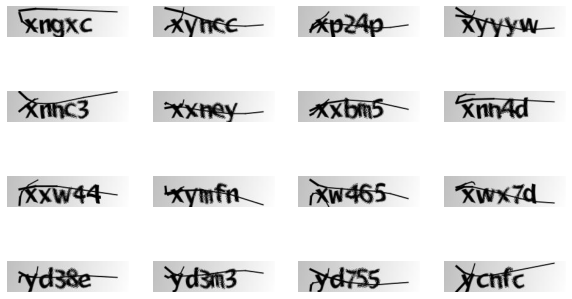

In [87]:
#теперь проверим результат на тестовых данных, которые не были использованы в обучении модели

#создаем тестовый датасет
data_dir1 = Path('/content/drive/MyDrive/тест')
# Список з изображений
images = list(data_dir1.glob("*.png"))
print("Number of images found: ", len(images))

#Посмотрим на наши данные 
sample_images1 = images[:16]

_,ax = plt.subplots(4,4, figsize=(10,6))
for i in range(16):
    img = cv2.imread(str(sample_images1[i]))
    
    ax[i//4, i%4].imshow(img)
    ax[i//4, i%4].axis('off')
plt.show()


In [88]:
# Store all the characters in a set
characters = set()

# A list to store the length of each captcha
captcha_length = []

# Store image-label info
dataset = []

# Iterate over the dataset and store the
# information needed
for img_path in images:
    # 1. Get the label associated with each image
    label = img_path.name.split(".png")[0]
    # 2. Store the length of this cpatcha
    captcha_length.append(len(label))
    # 3. Store the image-label pair info
    dataset.append((str(img_path), label))

        # 4. Store the characters present
    for ch in label:
        characters.add(ch)

# Sort the characters        
characters = sorted(characters)

# Convert the dataset info into a dataframe
dataset = pd.DataFrame(dataset, columns=["img_path", "label"], index=None)

# Shuffle the dataset
dataset = dataset.sample(frac=1.).reset_index(drop=True)
print("Number of unqiue charcaters in the whole dataset: ", len(characters))
print("Maximum length of any captcha: ", max(Counter(captcha_length).keys()))
print("Characters present: ", characters)
print("Total number of samples in the dataset: ", len(dataset))
print('Несколько примеров данных')
dataset.head()

Number of unqiue charcaters in the whole dataset:  19
Maximum length of any captcha:  5
Characters present:  ['2', '3', '4', '5', '6', '7', '8', 'b', 'c', 'd', 'e', 'f', 'g', 'm', 'n', 'p', 'w', 'x', 'y']
Total number of samples in the dataset:  16
Несколько примеров данных


,img_path,label
0,/content/drive/MyDrive/тест/ycnfc.png,ycnfc
1,/content/drive/MyDrive/тест/xymfn.png,xymfn
2,/content/drive/MyDrive/тест/xwx7d.png,xwx7d
3,/content/drive/MyDrive/тест/xnn4d.png,xnn4d
4,/content/drive/MyDrive/тест/xw465.png,xw465


In [105]:
# генерируем кортежи, состоящие из двух элементов - индекс и сам элемент 
char_to_labels = {char:idx for idx, char in enumerate(characters)}

# переводим в char
labels_to_char = {val:key for key, val in char_to_labels.items()}

# Проверяем работоспособность поврежденных данных
def is_valid_captcha(captcha):
    for ch in captcha:
        if not ch in characters:
            return False
    return True



# Запишем массивы в памяти
def generate_arrays(df, resize=True, img_height=50, img_width=200):
  num_items = len(df)
  images = np.zeros((num_items, img_height, img_width), dtype=np.float32) #задаем размер входного массива и определяем тип данных 
  labels = [0]*num_items
    
  for i in range(num_items): 
      img = cv2.imread(df["img_path"][i])
      img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        
      if resize: 
          img = cv2.resize(img, (img_width, img_height))
        
      img = (img/255.).astype(np.float32)
      label = df["label"][i]
        
        # если valid_capcha
      if is_valid_captcha(label):
          images[i, :, :] = img
          labels[i] = label
    
  return images, np.array(labels)

# Создаем training data
test, test_labels = generate_arrays(df=dataset)


    

In [112]:
  # Генератор для тестовых данных 
test_data_generator = DataGenerator(data=test,
                                     labels=test_labels,
                                     char_map=char_to_labels,
                                     batch_size=batch_size,
                                     img_width=img_width,
                                     img_height=img_height,
                                     downsample_factor=downsample_factor,
                                     max_length=max_length,
                                     shuffle=False
                                    )


In [111]:
scores = model.evaluate(test_data_generator, verbose=1)

1/1 [==============================] - 0s 1ms/step - loss: 0.0442


<function matplotlib.pyplot.show>

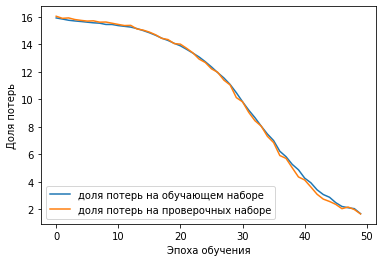

In [156]:
plt.plot(history.history['loss'],
         label = 'доля потерь на обучающем наборе')
plt.plot(history.history['val_loss'],
         label = 'доля потерь на проверочных наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля потерь')
plt.legend()
plt.show

TypeError: ignored